## Advanced Machine Learning
### Practical 5 - Continual Learning

In this practical, we will train a continual learning model on a task-incremental learning (CIL) problem.


### Task-Incremental Learning

In this setting, rather than training a model with access to all our data at any time, we imagine that our training process occurs over several discrete timesteps.

- At each different timestep, our model is learning a different task on different data.
- Importantly, we do **not** have access to the data from other timesteps.
- At inference, we want the model to be able to solve any of the tasks it has been previously trained on.
- This means, both at inference and training, we must provide our model a 'task ID' that tells it which task to perform.

The simple thing to do in this setting is to train our model on the data at each timestep, adding a new task head when needed. This is straightforward transfer learning, and we will see the **catastrophic forgetting** problem in action when fine-tuning the model on a new task ruins its performance on previous ones.

You will solve the catastrophic forgetting problem by implementing the **Learning without Forgetting (LwF)** algorithm. This algorithm allows a model to learn new tasks while constraining performance on old tasks using distillation, all without access to the old data.

But first, let's set up the problem and see what the baseline transfer learning implementation looks like in this setting.


#### How to run this practical

If you don't have a GPU on your machine, you can download this notebook and upload it to [Kaggle](https://www.kaggle.com/code) or [Colab](https://colab.research.google.com/) to use their GPU resources. 
- You'll need to toggle on GPU acceleration in whichever one you use. On Kaggle you have to toggle on internet access as well.
- Kaggle seems to be much more reliable in practice, but use whatever works for you.

In [3]:
# set up the environment and install any missing packages:
!pip install torch torchvision numpy scipy matplotlib pandas pillow tqdm

import torch
from torch import nn, utils
import torch.nn.functional as F
from torchvision import models, datasets, transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
from PIL import Image
from tqdm import tqdm
import os

/Users/dani/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

For our dataset, we'll use [Fashion-MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist). This is a 10-way classification dataset on different types of clothing garments.

It has similar properties to the classic MNIST data - the same image resolution, number of classes and examples per class - but is a bit less trivial, so requires a slightly higher-capacity model that learns some more subtle features.

Below, we download the dataset and display some examples from it.

In [4]:
### download data:

fmnist = datasets.FashionMNIST(root='data/', download=True)
fmnist.name, fmnist.num_classes = 'Fashion-MNIST', len(fmnist.classes)
print(f'{fmnist.name}: {len(fmnist)} samples')

for i, cl in enumerate(fmnist.classes):
    print(f'{i}: {cl}')

Fashion-MNIST: 60000 samples
0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


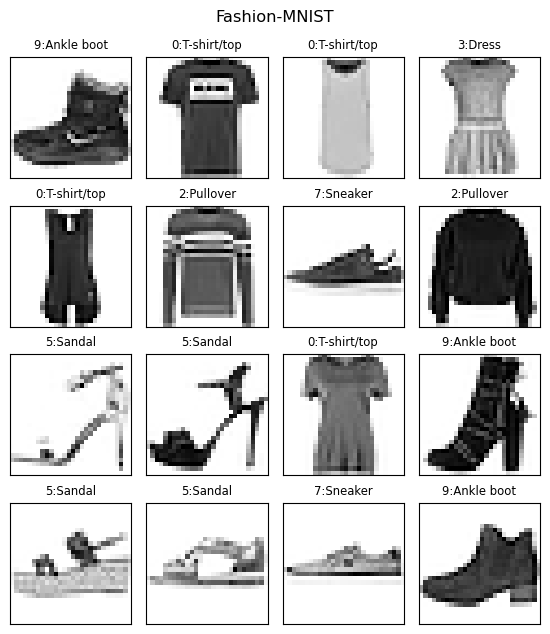

In [5]:
### helper function to inspect torch image batches:

def inspect_batch(images, # batch of images as torch tensors
        labels=None,      # optional vector of ground truth label integers
        predictions=None, # optional vector/matrix of model predictions
        # display parameters:
        class_names=None, # optional list or dict of class idxs to class name strings
        title=None,       # optional title for entire plot    
        # figure display/sizing params:
        center_title=True,
        max_to_show=16,
        num_cols = 4,
        scale=1,
        ):
    """accepts a batch of images as a torch tensor or list of tensors,
    and plots them in a grid for manual inspection.
    optionally, you can supply ground truth labels
    and/or model predictions, to display those as well."""

    max_to_show = min([max_to_show, len(images)]) # cap at number of images
    
    num_rows = int(np.ceil(max_to_show / num_cols))

    # add extra figure height if needed for captions:
    extra_height = (((labels is not None) or (predictions is not None)) * 0.2)

    fig_width = 2 * scale * num_cols
    fig_height = (2+extra_height) * scale * num_rows + ((title is not None) * 0.3)
    
    fig, axes = plt.subplots(num_rows, num_cols, squeeze=False, figsize=(fig_width, fig_height))
    all_axes = []
    for ax_row in axes:
        all_axes.extend(ax_row)

    # translate labels and predictions to class names if given:
    if class_names is not None:
        if labels is not None:
            labels = [f'{l}:{class_names[int(l)]}' for l in labels]
        if predictions is not None:
            if len(predictions.shape) == 2:
                # probability distribution or onehot vector, so argmax it:
                predictions = predictions.argmax(dim=1)
            predictions = [f'{p}:{class_names[int(p)]}' for p in predictions]
    
    for b, ax in enumerate(all_axes):
        if b < max_to_show:
            # rearrange to H*W*C:
            img_p = images[b].permute([1,2,0]) 
            # un-normalise:
            img = (img_p - img_p.min()) / (img_p.max() - img_p.min())
            # to numpy:
            img = img.cpu().detach().numpy()
            
            ax.imshow(img, cmap='Grays')
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])

            if labels is not None:                    
                ax.set_title(f'{labels[b]}', fontsize=10*scale**0.5)
            if predictions is not None:
                ax.set_title(f'pred: {predictions[b]}', fontsize=10*scale**0.5)
            if labels is not None and predictions is not None:
                if labels[b] == predictions[b]:
                    ### matching prediction, mark as correct:
                    mark, color = '✔', 'green'
                else:
                    mark, color = '✘', 'red'
                
                ax.set_title(f'label:{labels[b]}    \npred:{predictions[b]} {mark}', color=color, fontsize=8*scale**0.5)
        else:
            ax.axis('off')
    if title is not None:
        if center_title:
            x, align = 0.5, 'center'
        else:
            x, align = 0, 'left'
        fig.suptitle(title, fontsize=14*scale**0.5, x=x, horizontalalignment=align)
    fig.tight_layout()
    plt.show()



# define preprocessing transform and load a batch to inspect it:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

fmnist_batch = [fmnist[i] for i in range(16)]
fmnist_images = [preprocess(img) for (img,label) in fmnist_batch]
fmnist_labels = [label for (img,label) in fmnist_batch]

inspect_batch(fmnist_images, fmnist_labels, class_names=fmnist.classes, title='Fashion-MNIST', scale=0.7)

Below, we set up the task-incremental scenario. I define a number of timesteps, and allocate a subset of the FMNIST classes to each step. 

We will have a train/validation split for each step, as well as a final test set containing unseen data from all timesteps.

<sub>(this could also be framed as a class-incremental learning setting, but we are treating each classification problem as a different 'task' like in the meta-learning practical)</sub>

Time 0: Task ID 0, 10200 train, 1200 validation, 600 test


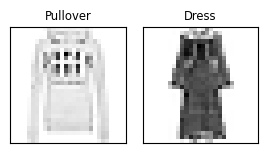

Time 1: Task ID 1, 10200 train, 1200 validation, 600 test


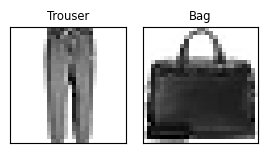

Time 2: Task ID 2, 15300 train, 1800 validation, 900 test


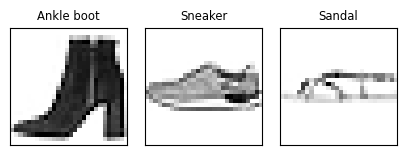

Time 3: Task ID 3, 15300 train, 1800 validation, 900 test


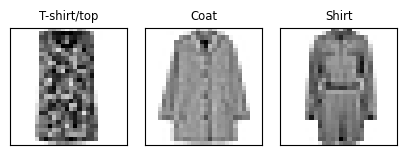

Final test set size (containing all tasks): 3000
Joint training set size (containing all tasks): 51000


In [6]:
# divide the classes along different time steps:

timestep_task_classes = {
    0: ['Pullover', 'Dress'], # task 0
    1: ['Trouser', 'Bag'],   # task 1
    2: ['Ankle boot', 'Sneaker', 'Sandal'], # task 2
    3: ['T-shirt/top', 'Coat', 'Shirt'], # task 3
    }

# PIL image preprocessing transform:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# quick function for displaying the classes of a task:
def inspect_task(task_data, title=None):
    num_task_classes = len(task_data.classes)
    task_classes = tuple([str(c) for c in task_data.classes])

    class_image_examples = [[batch[0] for batch in task_data if batch[1]==c][0] for c in range(num_task_classes)]
    inspect_batch(class_image_examples, labels=task_classes, scale=0.7, num_cols=num_task_classes, title=title, center_title=False)


# data/loader constants:
VAL_FRAC = 0.1
TEST_FRAC = 0.05
BATCH_SIZE = 256

# build task datasets for each timestep:
timestep_tasks = {}
timestep_loaders = {}

task_test_sets = []

for t, task_classes in timestep_task_classes.items():
    task_class_labels = [fmnist.class_to_idx[cl] for cl in task_classes] # original labels in fmnist source data
    task_datapoint_idxs = [i for i,label in enumerate(fmnist.targets) if label in task_class_labels]
    
    task_datapoints = [fmnist[idx] for idx in task_datapoint_idxs]
    
    class_to_idx = {task_classes[t]: t for t in range(len(task_classes))}
    
    task_images = [preprocess(img) for (img, label) in task_datapoints]
    task_labels = [class_to_idx[fmnist.classes[label]] for (img, label) in task_datapoints] # new labels

    # in addition to the images and labels, each task dataset now comes with a 'task id'
    # that tells the model which learned task to perform:
    task_ids = [t] * len(task_datapoints)
    
    task_image_tensor = torch.Tensor(torch.stack(task_images))
    task_label_tensor = torch.Tensor(task_labels).long()
    task_id_tensor = torch.Tensor(task_ids).long()
    
    task_data = utils.data.TensorDataset(task_image_tensor, task_label_tensor, task_id_tensor)

    # train/validation split:
    train_frac  = 1.0 - VAL_FRAC - TEST_FRAC
    task_train, task_val, task_test = utils.data.random_split(task_data, [train_frac, VAL_FRAC, TEST_FRAC])
    
    # set dataset attributes to reflect what they contain:
    for data in (task_train, task_val, task_test):
        data.classes      = task_classes
        data.num_classes  = len(task_classes)
        data.class_to_idx = class_to_idx
        data.task_id      = t

    # inspect samples of both classes:
    print(f'Time {t}: Task ID {t}, {len(task_train)} train, {len(task_val)} validation, {len(task_test)} test')
    inspect_task(task_train)

    # add train/val data to timestep dict, and test data to the list of test sets
    timestep_tasks[t] = task_train, task_val
    task_test_sets.append(task_test)


# for final evaluation of the model, we evaluate on all task test sets jointly:
final_test_data = utils.data.ConcatDataset(task_test_sets)
final_test_loader = utils.data.DataLoader(final_test_data, 
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)
print(f'Final test set size (containing all tasks): {len(final_test_data)}')


# and we will also run a joint training loop on the whole training dataset at once to see upper bound performance
joint_train_data = utils.data.ConcatDataset([train for train,val in timestep_tasks.values()])
joint_train_loader = utils.data.DataLoader(joint_train_data, 
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

print(f'Joint training set size (containing all tasks): {len(joint_train_data)}')


In [7]:
# we can verify that drawing a sample from this data produces a (image, label, task_id) triplet:

example = task_train[0]
image, label, task_id = example

print(f'\n image: {type(image)}  of shape {image.shape}')

print(f'\n label: {label}   (class: {task_train.classes[label]})')

print(f'\n task id: {task_id}   (classification between: {timestep_task_classes[int(task_id)]})')



 image: <class 'torch.Tensor'>  of shape torch.Size([1, 28, 28])

 label: 1   (class: Coat)

 task id: 3   (classification between: ['T-shirt/top', 'Coat', 'Shirt'])


## Models

Here we define the model classes we will use.

The dataset images are small, and monochrome, so we can get away with a small hand-built CNN backbone instead of a fancy pre-built model, defined as `ConvBackbone` below.

We'll also use a separate `TaskHead` class for the specific classification heads, like last week. This will be a helpful abstraction for dealing with the discrete tasks in our TIL setting.

And finally, we define a `MultitaskModel` that combines the backbone with multiple task heads, and incorporates the 'task ID' routing in its `forward` method that allows task heads to be called selectively depending on the input task.



In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ConvBackbone(nn.Module):
    def __init__(self, 
                 layers=[32, 64, 128, 256, 512], # list of conv layer num_kernels
                 input_size=(1,32,32), # for grayscale images
                 device=device,
                ):
        super().__init__()

        in_channels, in_h, in_w = input_size        

        # build the sequential stack of conv layers:
        conv_layers = []
        prev_layer_size = in_channels
        for layer_size in layers:
            conv_layers.append(nn.Conv2d(prev_layer_size, layer_size, (3,3), padding='same'))
            conv_layers.append(nn.ReLU())
            prev_layer_size = layer_size
        self.conv_stack = torch.nn.Sequential(*conv_layers)
        
        # global average pooling to reduce to single dimension:
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        
        # number of output features:
        self.num_features = prev_layer_size
        
        self.relu = nn.ReLU()

        self.device = device
        self.to(device)
    
    def forward(self, x):
        # pass through conv layers:
        x = self.conv_stack(x)
        
        # downsample and reshape to vector:
        x = self.pool(x)
        x = x.view(-1, self.num_features)

        # return feature vector:
        return x


### as before, define a classification head that we can attach to the backbone:
class TaskHead(nn.Module):
    def __init__(self, input_size: int, # number of features in the backbone's output
                 projection_size: int,  # number of neurons in the hidden layer
                 num_classes: int,      # number of output neurons
                 dropout: float=0.,     # optional dropout rate to apply
                 device=device):
        super().__init__()
        
        self.projection = nn.Linear(input_size, projection_size)
        self.classifier = nn.Linear(projection_size, num_classes)

        if dropout > 0:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = nn.Identity()

        self.relu = nn.ReLU()

        self.device = device
        self.to(device)

    def forward(self, x):
        # assume x is already unactivated feature logits,
        # e.g. from resnet backbone
        x = self.projection(self.relu(self.dropout(x)))
        x = self.classifier(self.relu(self.dropout(x)))

        return x


### and a model that contains a backbone plus multiple class heads,
### and performs task-ID routing at runtime, allowing it to perform any learned task:
class MultitaskModel(nn.Module):
    def __init__(self, backbone: nn.Module, 
                 device=device):
        super().__init__()

        self.backbone = backbone

        # a dict mapping task IDs to the classification heads for those tasks:
        self.task_heads = nn.ModuleDict()        
        # we must use a nn.ModuleDict instead of a base python dict,
        # to ensure that the modules inside are properly registered in self.parameters() etc.

        self.relu = nn.ReLU()
        self.device = device
        self.to(device)

    def forward(self, 
                x: torch.Tensor, 
                task_id: int):
        
        task_id = str(int(task_id))
        # nn.ModuleDict requires string keys for some reason,
        # so we have to be sure to cast the task_id from tensor(2) to 2 to '2'
        
        assert task_id in self.task_heads, f"no head exists for task id {task_id}"
        
        # select which classifier head to use:
        chosen_head = self.task_heads[task_id]

        # activated features from backbone:
        x = self.relu(self.backbone(x))
        # task-specific prediction:
        x = chosen_head(x)

        return x

    def add_task(self, 
                 task_id: int, 
                 head: nn.Module):
        """accepts an integer task_id and a classification head
        associated to that task.
        adds the head to this model's collection of task heads."""
        self.task_heads[str(task_id)] = head

    @property
    def num_task_heads(self):
        return len(self.task_heads)

## Baseline Training

As a baseline, we'll perform 'basic' transfer learning (without any specific CL algorithm) by simply training on the data at each time-step as it comes in, adding a new task head when necessary.

Below we define the baseline data loaders, as well as the usual helper functions for metric plotting.

<sub>(I finally made the `metrics` object a dict instead of a stupid list, so hopefully it is easier to work with now)</sub>

In [9]:
### plotting and accuracy functions:

# for this exercise, the training_plot function is able to separate the training curves
# at different timesteps, since these are different tasks with unrelated losses.
# there's also some extra functionality to plot 'soft_loss' from your LwF algorithm, if provided.
def training_plot(metrics, 
      title=None, # optional figure title
      alpha=0.05, # smoothing parameter for train loss
      baselines=None, # optional list, or named dict, of baseline accuracies to compare to
      show_epochs=False,    # display boundary lines between epochs
      show_timesteps=False, # display discontinuities between CL timesteps
      ):

    for metric_name in 'train_losses', 'val_losses', 'train_accs', 'val_accs', 'epoch_steps':
        assert metric_name in metrics, f"{metric_name} missing from metrics dict"
    
    fig, (loss_ax, acc_ax) = plt.subplots(1,2)

    # determine where to place boundaries, by calculating steps per epoch and epochs per timestep:
    steps_per_epoch = int(np.round(len(metrics['train_losses']) / len(metrics['val_losses']))) 
    epochs_per_ts = int(np.round(len(metrics['epoch_steps']) / len(metrics['CL_timesteps']))) 
    
    # if needing to show timesteps, we plot the curves discontinuously:
    if show_timesteps:
        # break the single list of metrics into nested sub-lists:
        timestep_train_losses, timestep_val_losses = [], []
        timestep_train_accs, timestep_val_accs = [], []
        timestep_epoch_steps, timestep_soft_losses = [], []
        prev_ts = 0
        for t, ts in enumerate(metrics['CL_timesteps']):
            timestep_train_losses.append(metrics['train_losses'][prev_ts:ts])
            timestep_train_accs.append(metrics['train_accs'][prev_ts:ts])
            timestep_val_losses.append(metrics['val_losses'][t*epochs_per_ts:(t+1)*epochs_per_ts])
            timestep_val_accs.append(metrics['val_accs'][t*epochs_per_ts:(t+1)*epochs_per_ts])
            timestep_epoch_steps.append(metrics['epoch_steps'][t*epochs_per_ts:(t+1)*epochs_per_ts])
            if 'soft_losses' in metrics:
                timestep_soft_losses.append(metrics['soft_losses'][prev_ts:ts])
            else:
                timestep_soft_losses.append(None)
            prev_ts = ts
    else: 
        # just treat this as one timestep, by making lists of size 1:
        timestep_train_losses = [metrics['train_losses']]
        timestep_train_accs = [metrics['train_accs']]
        timestep_val_losses = [metrics['val_losses']]
        timestep_val_accs = [metrics['val_accs']]
        timestep_epoch_steps = [metrics['epoch_steps']]
        if 'soft_losses' in metrics:
            timestep_soft_losses = metrics['soft_losses']
        else:
            timestep_soft_losses = [None]

    # zip up the individual curves at each timestep:
    timestep_metrics = zip(timestep_train_losses,
                          timestep_train_accs,
                          timestep_val_losses,
                          timestep_val_accs,
                          timestep_epoch_steps,
                          metrics['CL_timesteps'],
                          timestep_soft_losses)
    
    for train_losses, train_accs, val_losses, val_accs, epoch_steps, ts, soft_losses in timestep_metrics:
        ### plot loss:
        smooth_train_loss = pd.Series(train_losses).ewm(alpha=alpha).mean()
        steps = np.arange(ts-len(train_losses), ts)
    
        # train loss is plotted at every step:
        loss_ax.plot(steps, smooth_train_loss, 'b-', label=f'train loss')
        # but val loss is plotted at every epoch:
        loss_ax.plot(epoch_steps, val_losses, 'r-', label=f'val loss')

        ### plot soft loss if given:
        if soft_losses is not None:
            smooth_soft_loss = pd.Series(soft_losses).ewm(alpha=alpha).mean()
            loss_ax.plot(steps, smooth_soft_loss, 'g-', label=f'soft loss')
        
        ### plot acc:
        smooth_train_acc = pd.Series(train_accs).ewm(alpha=alpha).mean()
        
        acc_ax.plot(steps, smooth_train_acc, 'b-', label=f'train acc')
        acc_ax.plot(epoch_steps, val_accs, 'r-', label=f'val acc')

        
    loss_legend = ['train loss', 'val loss'] if 'soft_loss' not in metrics else ['train loss', 'val loss', 'soft loss']
    acc_legend = ['train acc', 'val acc']
    
    loss_ax.legend(loss_legend); loss_ax.set_xlabel(f'Training step'); loss_ax.set_ylabel(f'Loss (CXE)')
    acc_ax.legend(acc_legend); acc_ax.set_xlabel(f'Training step'); acc_ax.set_ylabel(f'Accuracy')

    # format as percentage on right:
    acc_ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))
    acc_ax.yaxis.tick_right()
    acc_ax.yaxis.set_label_position('right')

    # optionally, draw lines at baseline accuracy points:
    if baselines is not None:
        if type(baselines) is list:
            for height in baselines:
                acc_ax.axhline(height, c=[0.8]*3, linestyle=':')
            # rescale y-axis to accommodate baselines if needed:
            plt.ylim([0, max(list(smooth_train_acc) + metrics['val_accs'] + baselines)+0.05])                
        elif type(baselines) is dict:
            for name, height in baselines.items():
                acc_ax.axhline(height, c=[0.8]*3, linestyle=':')
                # add text label as well:
                acc_ax.text(0, height+0.002, name, c=[0.6]*3, size=8)
            plt.ylim([0, max(list(smooth_train_acc) + metrics['val_accs'] + [h for h in baselines.values()])+0.05])                  

    # optionally, draw epoch boundaries
    if show_epochs:
        for ax in (loss_ax, acc_ax):
            for epoch in metrics['epoch_steps']:
                ax.axvline(epoch, c=[0.9]*3, linestyle=':', zorder=1)
    
    # and/or CL timesteps:
    if show_timesteps:
        for ax in (loss_ax, acc_ax):
            for epoch in metrics['CL_timesteps']:
                ax.axvline(epoch, c=[.7,.7,.9], linestyle='--', zorder=0)

    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def get_batch_acc(pred, y):
    """calculates accuracy over a batch as a float
    given predicted logits 'pred' and integer targets 'y'"""
    return (pred.argmax(axis=1) == y).float().mean().item()

Below are functions to evaluate the multitask model on a specific validation loader, as well as a final test function that performs this evaluation across the test set for all tasks seen so far:

In [10]:

#### basic evaluation function for a multitask model
#### over some specified validation loader,
#### expecting the correct task IDs:
def evaluate_model(multitask_model: nn.Module,  # trained model capable of multi-task classification
                   val_loader: utils.data.DataLoader,  # task-specific data to evaluate on
                   loss_fn: nn.modules.loss._Loss = nn.CrossEntropyLoss(),
                  ):
    """runs model on entirety of validation loader,
    with specified loss and accuracy functions,
    and returns average loss/acc over all batches"""
    with torch.no_grad():
        batch_val_losses, batch_val_accs = [], []
    
        for batch in val_loader:
            vx, vy, task_ids = batch
            vx, vy = vx.to(device), vy.to(device)
            
            vpred = multitask_model(vx, task_ids[0])
            val_loss = loss_fn(vpred, vy)
            val_acc = get_batch_acc(vpred, vy)
            
            batch_val_losses.append(val_loss.item())
            batch_val_accs.append(val_acc)
    return np.mean(batch_val_losses), np.mean(batch_val_accs)


#### we will also evaluate the model on the test sets of all the tasks seen so far,
#### which also lets us see the final overall performance at the end of the run
def test_evaluate(multitask_model: nn.Module,   # trained model capable of multi-task classification
                  selected_test_sets: list[utils.data.Dataset], # task-specific test sets to evaluate on
                  prev_accs: list[list[float]] = None, # previous taskwise accuracies of this model,
                                                       # to show catastrophic forgetting gaps
                  show_taskwise_accuracy=True, # show bar plot indicating performance on each separate task
                  baseline_taskwise_accs: list[float]=None, # optional baseline performance on each task for comparison
                  model_name: str='', # optional model name to show in plots
                  verbose=False, # more detailed output to console
                 ):
    if verbose:
        print(f'{model_name} evaluation on test set of all tasks:'.capitalize())

    task_test_losses = []
    task_test_accs = []

    for t, test_data in enumerate(selected_test_sets):
        test_loader = utils.data.DataLoader(test_data, 
                                       batch_size=BATCH_SIZE,
                                       shuffle=True)
        
        task_test_loss, task_test_acc = evaluate_model(multitask_model, test_loader)

        if verbose:
            print(f'{test_data.classes}: {task_test_acc:.2%}')
            if baseline_taskwise_accs is not None:
                print(f'(baseline: {baseline_taskwise_accs[t]:.2%})')
        
        task_test_losses.append(task_test_loss)
        task_test_accs.append(task_test_acc)
        
    avg_task_test_loss = np.mean(task_test_losses)
    avg_task_test_acc = np.mean(task_test_accs)

    if verbose:
        print(f'\n +++ AVERAGE TASK TEST ACCURACY: {avg_task_test_acc:.2%} +++ ')


    if show_taskwise_accuracy:
        bar_heights = task_test_accs + [0]*(len(task_test_sets) - len(selected_test_sets))
        # display bar plot with accuracy on each evaluation task
        plt.bar(x = range(len(task_test_sets)), height=bar_heights, zorder=1)
        plt.xticks(range(len(task_test_sets)), [','.join(task.classes) for task in task_test_sets], rotation='vertical')
        plt.axhline(avg_task_test_acc, c=[0.4]*3, linestyle=':')
        plt.text(0, avg_task_test_acc+0.002, f'{model_name} (average)', c=[0.4]*3, size=8)

        if prev_accs is not None:
            # plot the previous step's accuracies on top
            # (will show forgetting in red)
            for p, prev_acc_list in enumerate(prev_accs):
                plt.bar(x = range(len(prev_acc_list)), height=prev_acc_list, fc='tab:red', zorder=0, alpha=0.5*((p+1)/len(prev_accs)))

        if baseline_taskwise_accs is not None:
            for t, acc in enumerate(baseline_taskwise_accs):
                plt.plot([t-0.5, t+0.5], [acc, acc], c='black', linestyle='--')

            # show average as well:
            baseline_avg = np.mean(baseline_taskwise_accs)
            plt.axhline(baseline_avg, c=[0.6]*3, linestyle=':')
            plt.text(0, baseline_avg+0.002, 'baseline average', c=[0.6]*3, size=8)
            
        plt.show()
    
    return task_test_accs

Finally, we define the continual learning training loop here. 
- We set some hyperparameters and do an outer loop over each timestep, drawing the appropriate data for each timestep.
- Inside each timestep, we define a head for the current task, and perform a normal model training loop on that task.
- This updates the model backbone together with the new task head, but leaves heads for previous tasks unchanged.

Training on task id: 0  (classification between: ['Pullover', 'Dress'])


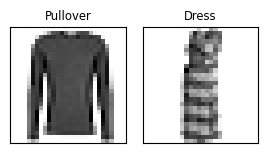

  Adding new task head 0 to multi-task model


E0 batch loss:0.21, batch acc:90.7%: 100%|██████████████████████████| 40/40 [16:40<00:00, 25.01s/it]


E0 loss:0.41|v:0.20| acc t:80.3%|v:92.5%


E1 batch loss:0.20, batch acc:93.1%: 100%|██████████████████████████| 40/40 [16:09<00:00, 24.24s/it]


E1 loss:0.22|v:0.18| acc t:92.1%|v:93.0%


E2 batch loss:0.17, batch acc:94.4%: 100%|██████████████████████████| 40/40 [15:56<00:00, 23.91s/it]


E2 loss:0.17|v:0.15| acc t:94.0%|v:94.1%


E3 batch loss:0.14, batch acc:94.4%: 100%|██████████████████████████| 40/40 [16:42<00:00, 25.05s/it]


E3 loss:0.17|v:0.20| acc t:94.3%|v:92.3%


E4 batch loss:0.19, batch acc:93.1%: 100%|██████████████████████████| 40/40 [16:06<00:00, 24.17s/it]


E4 loss:0.14|v:0.13| acc t:95.4%|v:95.6%


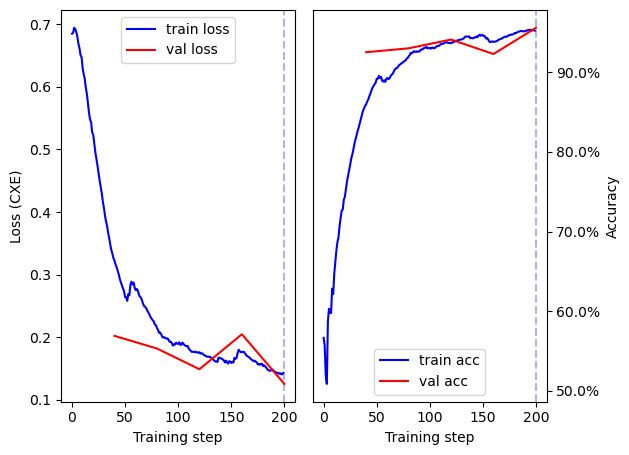

Best validation accuracy: 95.61%

Baseline at t=0 evaluation on test set of all tasks:
['Pullover', 'Dress']: 95.87%

 +++ AVERAGE TASK TEST ACCURACY: 95.87% +++ 


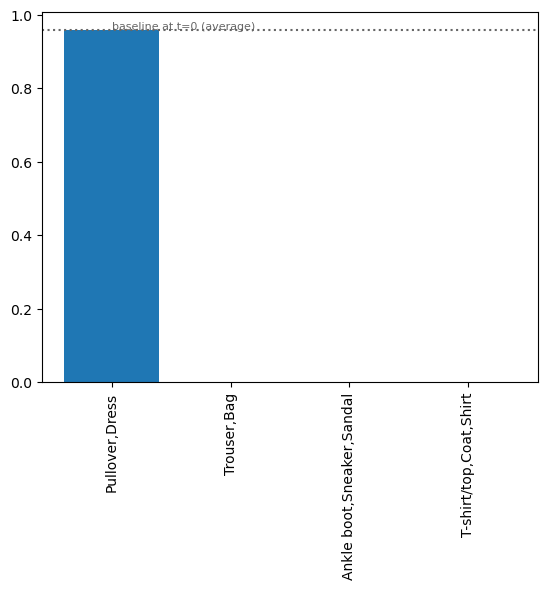

Training on task id: 1  (classification between: ['Trouser', 'Bag'])


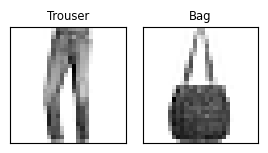

  Adding new task head 1 to multi-task model


E0 batch loss:0.19, batch acc:93.5%: 100%|██████████████████████████| 40/40 [16:55<00:00, 25.39s/it]


E0 loss:0.40|v:0.13| acc t:86.1%|v:96.1%


E1 batch loss:0.07, batch acc:98.1%: 100%|██████████████████████████| 40/40 [17:06<00:00, 25.67s/it]


E1 loss:0.11|v:0.06| acc t:96.7%|v:97.8%


E2 batch loss:0.05, batch acc:98.6%: 100%|██████████████████████████| 40/40 [15:47<00:00, 23.69s/it]


E2 loss:0.05|v:0.03| acc t:98.4%|v:99.3%


E3 batch loss:0.07, batch acc:98.6%: 100%|██████████████████████████| 40/40 [15:44<00:00, 23.62s/it]


E3 loss:0.03|v:0.03| acc t:99.0%|v:99.3%


E4 batch loss:0.03, batch acc:99.5%: 100%|██████████████████████████| 40/40 [16:11<00:00, 24.28s/it]


E4 loss:0.02|v:0.02| acc t:99.4%|v:99.2%


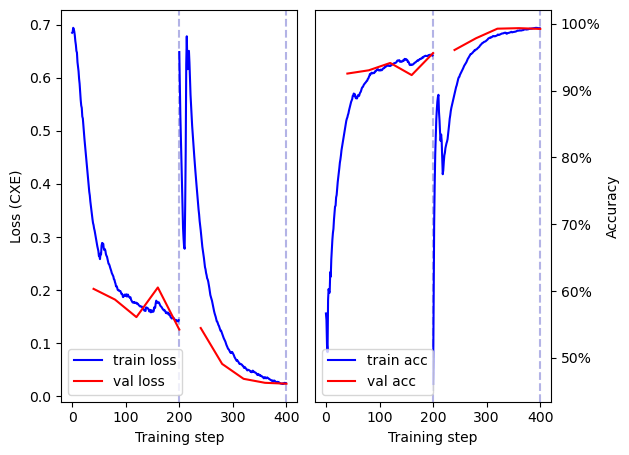

Best validation accuracy: 99.34%

Baseline at t=1 evaluation on test set of all tasks:
['Pullover', 'Dress']: 51.73%
['Trouser', 'Bag']: 99.87%

 +++ AVERAGE TASK TEST ACCURACY: 75.80% +++ 


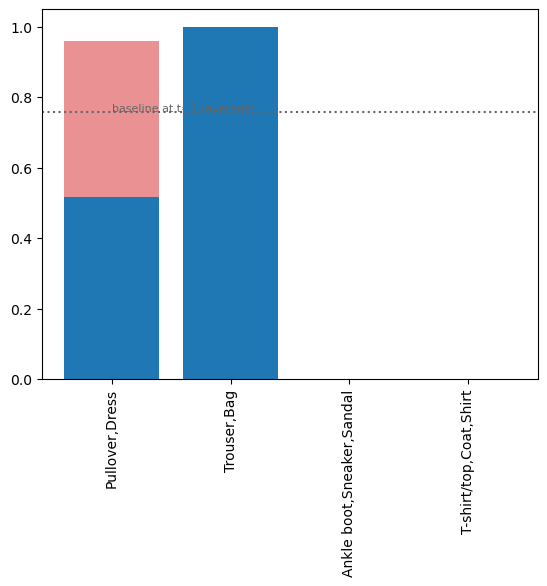

Training on task id: 2  (classification between: ['Ankle boot', 'Sneaker', 'Sandal'])


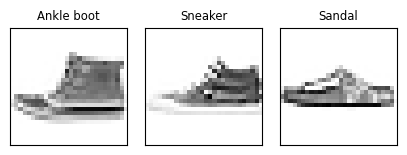

  Adding new task head 2 to multi-task model


E0 batch loss:0.52, batch acc:76.0%: 100%|██████████████████████████| 60/60 [25:07<00:00, 25.13s/it]


E0 loss:0.81|v:0.54| acc t:61.5%|v:80.2%


E1 batch loss:0.48, batch acc:82.7%: 100%|██████████████████████████| 60/60 [22:55<00:00, 22.92s/it]


E1 loss:0.45|v:0.43| acc t:82.6%|v:85.4%


E2 batch loss:0.38, batch acc:86.2%: 100%|██████████████████████████| 60/60 [23:57<00:00, 23.95s/it]


E2 loss:0.39|v:0.34| acc t:85.2%|v:88.7%


E3 batch loss:0.30, batch acc:90.8%: 100%|██████████████████████████| 60/60 [22:29<00:00, 22.49s/it]


E3 loss:0.34|v:0.40| acc t:87.5%|v:86.1%


E4 batch loss:0.25, batch acc:92.6%:  87%|██████████████████████▌   | 52/60 [20:52<03:12, 24.09s/it]


KeyboardInterrupt: 

In [9]:
torch.manual_seed(0)

# define backbone and place it inside the multitask model:
backbone = ConvBackbone()
multitask_model = MultitaskModel(backbone)

EPOCHS_PER_TIMESTEP = 5

### training hyperparameters:
lr     = 1e-3  # initial learning rate
l2_reg = 1e-4  # L2 weight decay term (0 means no regularisation)

### metrics and plotting:     
plot_training = True   # show training plots after each timestep
show_progress = True   # show progress bars and end-of-epoch metrics
verbose       = True   # output extra info to console

    
# define loss and optimiser:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(multitask_model.parameters(), lr=lr, weight_decay=l2_reg)


# track metrics for plotting training curves:
metrics = { 'train_losses': [],
              'train_accs': [],
              'val_losses': [],
                'val_accs': [],
             'epoch_steps': [], # used for plotting val loss at the correct x-position
            'CL_timesteps': [], # used to draw where each new timestep begins
            'best_val_acc': 0.0, # stores the best validation accuracy achieved so far
           'steps_trained': 0,
          }

# test accuracy on previous tasks, to check for forgetting:
prev_test_accs = []

# outer loop over each task, in sequence
for t, (task_train, task_val) in timestep_tasks.items():

    if verbose:
        print(f'Training on task id: {t}  (classification between: {task_train.classes})')
        inspect_task(task_train)
    
    if t not in multitask_model.task_heads:
        if verbose:
            print(f'  Adding new task head {t} to multi-task model')
            
        task_head = TaskHead(input_size=backbone.num_features, projection_size=64, num_classes=task_train.num_classes).to(device)
        multitask_model.add_task(t, task_head)

    # build train and validation loaders for the current task:
    train_loader, val_loader = [utils.data.DataLoader(data, 
                                 batch_size=BATCH_SIZE,
                                 shuffle=True)
                                for data in (task_train, task_val)]

    # inner loop over the current task:
    for e in range(EPOCHS_PER_TIMESTEP):
        epoch_train_losses, epoch_train_accs = [], []

        if show_progress:
            # set a progress bar to loop over
            batch_iter = tqdm(train_loader, ncols=100)
        else:
            batch_iter = train_loader
        
        for step, batch in enumerate(batch_iter):
            # get the image-label pair from the dataloader batch,
            # along with the task ID, which should be the same number across the whole batch
            x, y, task_ids = batch
            x, y = x.to(device), y.to(device)
    
            opt.zero_grad()

            # verify that task IDs are all the same, just in case:
            assert torch.all(task_ids == task_ids[0]), "mismatching task IDs within batch"
            task_id = task_ids[0]
            
            pred = multitask_model(x, task_id) # important to send task ID to the model!
            
            batch_loss = loss_fn(pred, y)
            batch_acc = get_batch_acc(pred, y)
    
            batch_loss.backward()
            opt.step()
    
            # track loss and accuracy:
            epoch_train_losses.append(batch_loss.item())
            epoch_train_accs.append(batch_acc)        
            metrics['steps_trained'] += 1

            if show_progress:
                # show loss/acc of this batch in progress bar:
                report = (f'E{e} batch loss:{batch_loss:.2f}, batch acc:{batch_acc:>5.1%}')
                batch_iter.set_description(report)

        # evaluate after each epoch on the current task's validation set:
        avg_val_loss, avg_val_acc = evaluate_model(multitask_model, val_loader, loss_fn)
        
        ### update metrics:
        metrics['epoch_steps'].append(metrics['steps_trained'])
        metrics['train_losses'].extend(epoch_train_losses)
        metrics['train_accs'].extend(epoch_train_accs)
        metrics['val_losses'].append(avg_val_loss)
        metrics['val_accs'].append(avg_val_acc)

        if show_progress:
            # print end-of-epoch stats:
            report = (f'E{e} loss:{np.mean(epoch_train_losses):.2f}|v:{avg_val_loss:.2f}' +
                                  f'| acc t:{np.mean(epoch_train_accs):>5.1%}|v:{avg_val_acc:>5.1%}')
            print(report)
            
        # update best accuracy:
        if avg_val_acc > metrics['best_val_acc']:
            metrics['best_val_acc'] = avg_val_acc

    # log the training steps between each continual-learning timestep:
    metrics['CL_timesteps'].append(metrics['steps_trained'])

    # plot training curves:
    if plot_training:
        training_plot(metrics, show_timesteps=True)

    if verbose:
        print(f'Best validation accuracy: {metrics["best_val_acc"]:.2%}\n')
    # clear the best accuracy for next timestep:
    metrics['best_val_acc'] = 0.0

    # evaluate on all tasks so far, and save the performance:
    task_test_accs = test_evaluate(multitask_model, task_test_sets[:t+1], model_name=f'baseline at t={t}', prev_accs = prev_test_accs, verbose=True)
    prev_test_accs.append(task_test_accs)

# record the baseline performance for comparison to your CL implementation
baseline_metrics = metrics
baseline_taskwise_test_accs = task_test_accs


At the end, we have the evaluation on the final test set, which contains all the tasks encountered so far.

We can see that despite achieving good accuracy on each task as the model trains, the final accuracy over all tasks is quite bad! The red areas on the bar chart indicate where catastrophic forgetting has occurred. 

Your objective is to fix this catastrophic forgetting, while maintaining the setting where data from previous tasks is not available at each time step. 

### Task: Continual Learning with LwF

To improve the test performance, you will implement the Learning-without-Forgetting algorithm for continual learning.

Recall this diagram from the lectures:

![lwf_in_context](https://i.imgur.com/J6OxV4V.png)

So far, the baseline implemented above is an example of case **(b)**. That is, naïvely fine-tuning the backbone together with the new task head; leaving the previous task head(s) unchanged, but modifying the backbone such that what it sends to the previous task head(s) may no longer make sense. We can see that this ruins the performance on previous tasks.

If we had access to previous data, we could mix this into the training at each time step. However, in this **incremental learning** setting we have only the data at the current time step. 

LwF tries to preserve performance on previous tasks without having to store any of the old data. 
- Instead, it requires us only to store the previous state of the model at the last time step.
- It adds an extra constraint in the form of a diffusion loss term for the previous task heads.
- This diffusion loss is calculated as the distance between the output distribution
- Effectively, the previous model is acting as a teacher for the current model, but only for the tasks that the current model cannot see.

The algorithm is formulated like this:

![lwf_algorithm](https://i.imgur.com/N07IT1M.png)

For each example, we calculate the joint loss, including:

- $L_{\textit{new}} (Y_n, \hat{Y}_n)$ is normal cross-entropy loss between the ground truth $Y_n$ and the prediction $\hat{Y}_n$ on the **current task head**. 
	
- $L_{\textit{old}} (Y_o, \hat{Y}_o) $ is the **distillation loss** between the previous model's output $Y_o$ and the current model's output $\hat{Y}_o$ on **previous task heads**.
	
- $ \lambda_o $ is a **stability** term that controls the stability-plasticity tradeoff.
	
- $ R(\hat{\theta}_s, \hat{\theta}_o, \hat{\theta}_n) $ is the usual weight decay regulariser term.



The distillation loss is exactly the same as what you implemented in practical 2 for knowledge distillation. You're all familiar with this already, so you can just use the `distillation_output_loss` implemented below:

In [1]:
def temperature_softmax(x, T):
    """applies softmax over channel dimension
    after re-scaling by chosen temperature arg T.
    returns a probability distribution of shape (batch, num_classes)"""
    return torch.softmax(x / T, dim=1)
    
def KL_divergence(p, q):
    """a measure of distance between two probability distributions.
    returns a positive scalar."""
    return torch.sum(p * torch.log(p / q), dim=-1)

def distillation_output_loss(student_pred, teacher_pred, temperature):
    """accepts unscaled logits from student and teacher model
    applies temperature-scaled softmax, and returns distillation loss
    as the KL-divergence between them, per example in the batch.
    output is a tensor of shape (batch,)"""

    student_soft = temperature_softmax(student_pred, temperature)
    teacher_soft = temperature_softmax(teacher_pred, temperature)

    kl_div = KL_divergence(student_soft, teacher_soft)

    return kl_div * temperature**2

Now, the rest is up to you. Implement the LwF algorithm on top of the continual-learning loop we used for the baseline earlier. Copy it and modify if you want. I have left some skeleton code below that will help with plotting the results, but the rest is up to you.

Some tips:
- The distillation loss above will be the 'soft loss' you add in each training step. If you add this loss to the `metrics` dict, you'll see it in your training plots.
  
- As you know, you can use a `temperature` term to control the softness of the teacher->student supervision. Try setting it to a similar value to whatever worked for you in the knowledge distillation practical.
  
- You might also find it useful to define a `stability` term to balance this soft loss with the usual hard label loss for the current classification task. How you define this term is up to you, but you may need to experiment with it to find a good trade-off between learning and forgetting.
  
- Feel free to change the number of epochs trained inside each timestep, or the other training hyperparameters - but for a fair comparison with the baseline, you should make the same change there as well, to ensure that any improvement in your method is due to the CL algorithm and not due to different training scenarios.

In [2]:
### Learning without Forgetting:
from copy import deepcopy

torch.manual_seed(0)

backbone = ConvBackbone()
multitask_model = MultitaskModel(backbone)
previous_model = None

### training hyperparameters:
EPOCHS_PER_TIMESTEP = 5
lr     = 1e-3  # initial learning rate
l2_reg = 1e-4  # L2 weight decay term (0 means no regularisation)
temperature = 2.0  # temperature scaling factor for distillation loss
stability = 1.0 #`stability` term to balance this soft loss with the usual hard label loss for the current classification task. 

# Initialize optimizer and loss function:
opt = torch.optim.Adam(multitask_model.parameters(), lr=lr, weight_decay=l2_reg)
loss_fn = nn.CrossEntropyLoss()

### metrics and plotting:     
plot_training = True   # show training plots after each timestep
show_progress = True   # show progress bars and end-of-epoch metrics
verbose       = True   # output extra info to console

# track metrics for plotting training curves:
metrics = { 'train_losses': [],
              'train_accs': [],
              'val_losses': [],
                'val_accs': [],
             'epoch_steps': [], # used for plotting val loss at the correct x-position
            'CL_timesteps': [], # used to draw where each new timestep begins
            'best_val_acc': 0.0,
           'steps_trained': 0,
             'soft_losses': [], # distillation loss
          }

prev_test_accs = []

# outer loop over each task, in sequence
for t, (task_train, task_val) in timestep_tasks.items():
    print(f"Training on task id: {t}  (classification between: {task_train.classes})")
    if verbose:
        inspect_task(task_train)
    
    if t not in multitask_model.task_heads:
        task_head = TaskHead(input_size=backbone.num_features, projection_size=64, num_classes=task_train.num_classes).to(device)
        multitask_model.add_task(t, task_head)
    
    # build train and validation loaders for the current task:
    train_loader, val_loader = [utils.data.DataLoader(data,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True)
                                    for data in (task_train, task_val)]

    # inner loop over the current task:
    for e in range(EPOCHS_PER_TIMESTEP):
        epoch_train_losses, epoch_train_accs = [], []
        epoch_soft_losses = []
        
        progress_bar = tqdm(train_loader, ncols=100) if show_progress else train_loader
        num_batches = len(train_loader)
        for batch_idx, batch in enumerate(progress_bar):
            #Get data from batch
            x, y, task_ids = batch
            x, y = x.to(device), y.to(device)
            task_id = task_ids[0]
            
            # zero the gradients
            opt.zero_grad()
            
            # get the predictions from the model
            pred = multitask_model(x, task_id)
            hard_loss = loss_fn(pred, y)
            
            #if previous model exists, calculate distillation loss
            soft_loss = 0.0
            if previous_model is not None:
                for old_task_id in range(t):
                    with torch.no_grad():
                        old_pred = previous_model(x, old_task_id)
                    new_prev_pred = multitask_model(x, old_task_id)
                    soft_loss += distillation_output_loss(new_prev_pred, old_pred, temperature).mean()
            
            #add the distillation loss to the total loss
            total_loss = hard_loss + stability * soft_loss
            
            #backpropagate the loss
            total_loss.backward()
            opt.step()
            
            # track loss and accuracy:
            epoch_train_losses.append(hard_loss.item())
            epoch_train_accs.append(get_batch_acc(pred, y))
            epoch_soft_losses.append(soft_loss.item() if isinstance(soft_loss, torch.Tensor) else soft_loss)
            metrics['steps_trained'] += 1
            
            if show_progress:
                # show loss/acc of this batch in progress bar:
                progress_bar.set_description((f'E{e} batch loss:{hard_loss:.2f}, batch acc:{epoch_train_accs[-1]:>5.1%}'))

        # evaluate after each epoch on the current task's validation set:
        avg_val_loss, avg_val_acc = evaluate_model(multitask_model, val_loader, loss_fn)
        
        ### update metrics:
        metrics['epoch_steps'].append(metrics['steps_trained'])
        metrics['train_losses'].extend(epoch_train_losses)
        metrics['train_accs'].extend(epoch_train_accs)
        metrics['val_losses'].append(avg_val_loss)
        metrics['val_accs'].append(avg_val_acc)
        metrics['soft_losses'].extend(epoch_soft_losses)
        
        if show_progress:
            # print end-of-epoch stats:
            print((f'E{e} loss:{np.mean(epoch_train_losses):.2f}|v:{avg_val_loss:.2f}' +
                                  f'| acc t:{np.mean(epoch_train_accs):>5.1%}|v:{avg_val_acc:>5.1%}'))

        if avg_val_acc > metrics['best_val_acc']:
            metrics['best_val_acc'] = avg_val_acc
        
    # this one is important for nice plots:
    metrics['CL_timesteps'].append(metrics['steps_trained']) 

    # plot training curves only if validation losses exist
    if plot_training and len(metrics['val_losses']) > 0:
        training_plot(metrics, show_timesteps=True)

    if verbose:
        print(f'Best validation accuracy: {metrics["best_val_acc"]:.2%}\n')
    metrics['best_val_acc'] = 0.0   

    # evaluate on all tasks:
    test_accs = test_evaluate(multitask_model, task_test_sets[:t+1], 
                              model_name=f'LwF at t={t}', 
                              prev_accs = prev_test_accs,
                              baseline_taskwise_accs = baseline_taskwise_test_accs, 
                              verbose=True)
    prev_test_accs.append(test_accs)
    
    #store the current model as the previous model
    previous_model = deepcopy(multitask_model)

final_avg_test_acc = np.mean(test_accs)
print(f'Final average test accuracy: {final_avg_test_acc:.2%}')
print(f'  (baseline): {np.mean(baseline_taskwise_test_accs):.2%}')

NameError: name 'torch' is not defined

### Assessment

If your implementation works, the performance of the CL model should be more-or-less comparable with the baseline on each new task, but much higher on the average of all tasks! 

Once you're happy with it, you should report your results as usual: 

* Show **a few plots** demonstrating your LwF implementation and how your model avoids forgetting performance on previous tasks, comparing its final test accuracy to that of the baseline model.
    
* Also write **a few sentences** summarising any particular issues you ran into, how you solved them, and any other insights you gained about designing/implementing your CL algorithm.

Good luck! If you have any problems, especially regarding understanding the task-incremental learning setting or the intuition behind the LwF algorithm, don't hesitate to ask for help.


# **Dynamic Tangent Space Realignment (TSR) with NTK for Continual Learning**

### This notebook adapts the baseline continual learning model to use a Dynamic Tangent Space Realignment (TSR) strategy, which dynamically updates the tangent space with the Neural Tangent Kernel (NTK) after learning each task. 

#### Each task is represented by a "task vector" in parameter space, which is aligned to the current NTK to retain knowledge of prior tasks without explicit data from them.
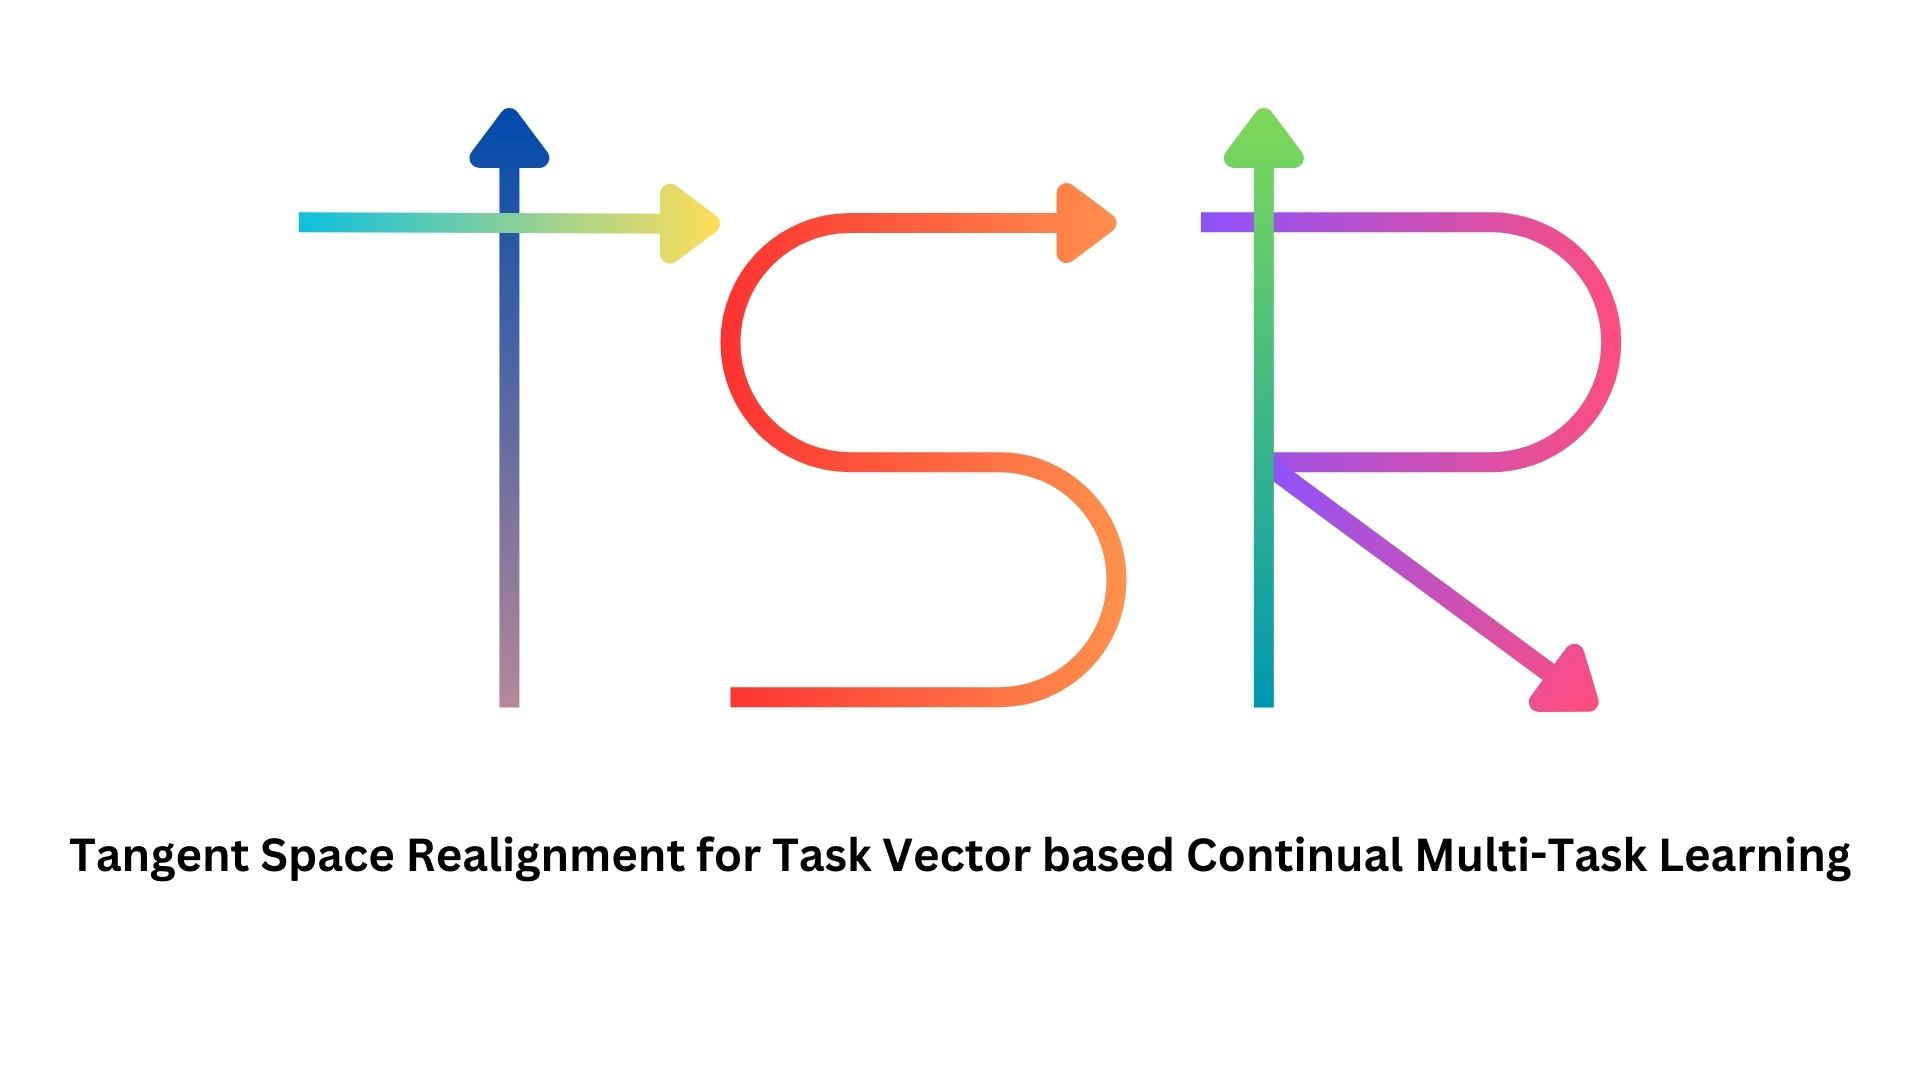

### NTK Calculation Function

In [17]:
# Function to calculate NTK matrix
def calculate_ntk(model, inputs, task_id):
    """
    Compute the NTK matrix for a given model and inputs.
    Parameters:
    - model: Neural network model
    - inputs: A batch of inputs
    Returns:
    - NTK matrix for the batch
    
    sources for the NTK calculation:
    https://github.com/google/neural-tangents
    https://pytorch.org/tutorials/intermediate/neural_tangent_kernels.html
    https://colab.research.google.com/github/google/neural-tangents/blob/main/notebooks/neural_tangents_cookbook.ipynb
    """

    model.eval()  # Set model to evaluation mode
    inputs = inputs.requires_grad_()  # Ensure inputs require gradients
    output = model(inputs, task_id)  # Forward pass
    ntk_matrix = None

    for i in range(output.shape[1]):  # Loop over output dimension (e.g., number of classes)
        grad_i = torch.autograd.grad(outputs=output[:, i].sum(), inputs=model.parameters(), create_graph=True) # Compute gradients of output w.r.t. model parameters. This is the first-order gradient (Jacobian) J = [∇θy1, ∇θy2, ..., ∇θyN]
        grad_flat = torch.cat([g.view(-1) for g in grad_i])  # Flatten and concatenate gradients into a single vector.

        # Calculate NTK matrix as the outer product of flattened gradients
        if ntk_matrix is None:
            ntk_matrix = torch.outer(grad_flat, grad_flat).unsqueeze(0) # Initialize NTK matrix with the outer product of the first output
        else:
            ntk_matrix += torch.outer(grad_flat, grad_flat).unsqueeze(0) # Add the outer product of the next output to the NTK matrix

    ntk_matrix = ntk_matrix.mean(0)  # Average over all outputs. This is the NTK matrix for the batch which is equal to K(x, x'; θ) = ∑_i ∇θy_i(x) * ∇θy_i(x') / N
    return ntk_matrix

### Realign Task Vectors Using NTK Basis

In [12]:
def realign_task_vectors(task_vectors, ntk_matrix, epsilon=1e-8) -> list:
    """
    Realign the task vectors using the NTK matrix.
    The realignment consists on the projection of the task vectors onto the new basis defined by the NTK matrix.
    Parameters:
    - task_vectors: List of task vectors
    - ntk_matrix: NTK matrix
    - epsilon: Small value to avoid division by zero
    Returns:
    - list of Realigned task vectors
    """
    
    # Decompose NTK matrix using eigen-decomposition to form a new basis
    eigenvalues, eigenvectors = torch.linalg.eigh(ntk_matrix)
    realigned_task_vectors = []

    for vector in task_vectors:
        # Project task vector onto the NTK eigenvectors (new basis)
        projection = eigenvectors.T @ vector

        # Normalize each projected component by the square root of the eigenvalue (scaled basis)
        realigned_vector = (projection / (torch.sqrt(eigenvalues) + epsilon)) @ eigenvectors.T
        realigned_task_vectors.append(realigned_vector)

    #return the realigned task vectors
    return realigned_task_vectors
    

In [13]:

# Function to compute tangent space addition of model and task vectors
def tangent_space_addition(model, task_vectors):
    """
    Perform tangent space addition of the model parameters and the task vectors for continual learning.
    the returned new model will be able to perform the new task without forgetting the previous ones and will
    be used for evaluation.
    Parameters:
    - model: Neural network model
    - task_vectors: List of task vectors
    Returns:
    - Updated model with added task vectors
    """
    updated_model = deepcopy(model)
    
    with torch.no_grad():  # Prevent gradient updates during addition
        for param, task_vector in zip(updated_model.parameters(), task_vectors):
            param.add_(task_vector)  # Add task vectors directly to parameters
    
    return updated_model

### Main Training Loop with TSR

In [ ]:
### TSR with NTK training

import torch
from torch import nn, utils, autograd
from copy import deepcopy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# We will use the previously defined ConvBackbone, TaskHead, and MultitaskModel classes
# as well as the evaluate_model, test_evaluate, training_plot, and other utility functions.

# Do not redefine ConvBackbone, TaskHead, MultitaskModel; use the previous definitions.

# Initialize the backbone and multitask model
backbone = ConvBackbone()
multitask_model = MultitaskModel(backbone)

# Training hyperparameters
EPOCHS_PER_TIMESTEP = 5
lr     = 1e-3  # initial learning rate
l2_reg = 1e-4  # L2 weight decay term (0 means no regularisation)

# Initialize optimizer and loss function:
opt = torch.optim.Adam(multitask_model.parameters(), lr=lr, weight_decay=l2_reg)
loss_fn = nn.CrossEntropyLoss()

### metrics and plotting:     
plot_training = True   # show training plots after each timestep
show_progress = True   # show progress bars and end-of-epoch metrics
verbose       = True   # output extra info to console

# track metrics for plotting training curves:
metrics = { 'train_losses': [],
              'train_accs': [],
              'val_losses': [],
                'val_accs': [],
             'epoch_steps': [], # used for plotting val loss at the correct x-position
            'CL_timesteps': [], # used to draw where each new timestep begins
            'best_val_acc': 0.0,
           'steps_trained': 0,
          }

# test accuracy on previous tasks, to check for catastrophic forgetting:
prev_test_accs = []

# Initialize task_vectors list to store task vectors
task_vectors = []

# Initialize list to store initial parameters after each task
initial_params_list = []


# outer loop over each task, in sequence
for t, (task_train, task_val) in timestep_tasks.items():
    print(f"Training on task id: {t}  (classification between: {task_train.classes})")
    if verbose:
        inspect_task(task_train)
    
    if t not in multitask_model.task_heads:
        task_head = TaskHead(input_size=backbone.num_features, projection_size=64, num_classes=task_train.num_classes).to(device)
        multitask_model.add_task(t, task_head)
    
    # build train and validation loaders for the current task:
    train_loader, val_loader = [utils.data.DataLoader(data,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True)
                                    for data in (task_train, task_val)]

    # inner loop over the current task:
    for e in range(EPOCHS_PER_TIMESTEP):
        epoch_train_losses, epoch_train_accs = [], []
        
        progress_bar = tqdm(train_loader, ncols=100) if show_progress else train_loader
        num_batches = len(train_loader)
        for batch_idx, batch in enumerate(progress_bar):
            # Get data from batch
            x, y, task_ids = batch
            x, y = x.to(device), y.to(device)
            task_id = task_ids[0]
            
            # zero the gradients
            opt.zero_grad()
            
            # get the predictions from the model
            pred = multitask_model(x, task_id)
            loss = loss_fn(pred, y)
            
            # backpropagate the loss
            loss.backward()
            opt.step()
            
            # track loss and accuracy:
            epoch_train_losses.append(loss.item())
            epoch_train_accs.append(get_batch_acc(pred, y))
            metrics['steps_trained'] += 1

            break
            
            if show_progress:
                # show loss/acc of this batch in progress bar:
                progress_bar.set_description((f'E{e} batch loss:{loss:.2f}, batch acc:{epoch_train_accs[-1]:>5.1%}'))

        # evaluate after each epoch on the current task's validation set:
        avg_val_loss, avg_val_acc = evaluate_model(multitask_model, val_loader, loss_fn)
        
        ### update metrics:
        metrics['epoch_steps'].append(metrics['steps_trained'])
        metrics['train_losses'].extend(epoch_train_losses)
        metrics['train_accs'].extend(epoch_train_accs)
        metrics['val_losses'].append(avg_val_loss)
        metrics['val_accs'].append(avg_val_acc)
        
        break
        if show_progress:
            # print end-of-epoch stats:
            print((f'E{e} loss:{np.mean(epoch_train_losses):.2f}|v:{avg_val_loss:.2f}' +
                                  f'| acc t:{np.mean(epoch_train_accs):>5.1%}|v:{avg_val_acc:>5.1%}'))

        if avg_val_acc > metrics['best_val_acc']:
            metrics['best_val_acc'] = avg_val_acc
        
    # Calculate NTK matrix after the current task and realign task vectors
    ntk_matrix = calculate_ntk(multitask_model, x, task_id=task_id)  # Compute NTK for the last batch of inputs
    task_vectors = realign_task_vectors(task_vectors, ntk_matrix)
    
    # this one is important for nice plots:
    metrics['CL_timesteps'].append(metrics['steps_trained']) 

    # plot training curves only if validation losses exist
    if plot_training and len(metrics['val_losses']) > 0:
        training_plot(metrics, show_timesteps=True)

    if verbose:
        print(f'Best validation accuracy: {metrics["best_val_acc"]:.2%}\n')
    metrics['best_val_acc'] = 0.0   

    # Evaluate on all tasks using tangent space addition of the multitask model and task vectors
    augmented_model = tangent_space_addition(multitask_model, task_vectors)
    test_accs = test_evaluate(augmented_model, task_test_sets[:t+1], 
                              model_name=f'LwF at t={t}', 
                              prev_accs = prev_test_accs,
                              baseline_taskwise_accs = baseline_taskwise_test_accs, 
                              verbose=True)
    prev_test_accs.append(test_accs)

final_avg_test_acc = np.mean(test_accs)
print(f'Final average test accuracy: {final_avg_test_acc:.2%}')
print(f'  (baseline): {np.mean(baseline_taskwise_test_accs):.2%}')
